# Price Data API

In [1]:
import pandas as pd
import numpy as np
import requests
import re

from datetime import date
from io import StringIO

In [2]:
def date_yf(dt):
    return (dt - date(1969, 12, 31)).days * 86400

def encode_yf(symbol, date_start, date_stop, interval):
    period1 = date_yf(date_start)
    period2 = date_yf(date_stop)
    
    return re.sub(r"(\n|\t| )", "", f"""
    https://query1.finance.yahoo.com/v7/finance/download/{symbol}
    ?period1={period1}
    &period2={period2}
    &interval={interval}
    &events=history&includeAdjustedClose=true
    """)

def download_yf_prices(symbol, date_start, date_stop, interval):
    uri = encode_yf(symbol, date_start, date_stop, interval)
    resp = requests.get(uri)
    
    if resp.status_code != 200:
        return None
    
    data = StringIO(resp.content.decode('utf-8'))
    
    return pd.read_csv(data, sep=",")

_Usage_

```python
download_yf_prices("BND", date(2000, 4, 9), date(2021, 1, 2), "1wk")
```

# Download

In [3]:
import os
import time

# Note that vanguard's "CORE_ETFS" = ["BND", "BNDX", "VTI", "VXUS"]
DATE_START = date(1995, 1, 1)
DATE_END   = date(2021, 1, 2)
CACHE_DIR = os.path.join("prices", "Jan_1995_Jan_2021")

if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)

vanguard = pd.read_csv("Vanguard_ETFs.csv")
vanguard.head(5)

,Category,Name,Symbol,Class,ER
0,Treasury/Agency,Extended Duration Treasury ETF,EDV,Bond - Long-term Government,0.07%
1,Treasury/Agency,Vanguard Select FundsIntermediate-Term Bond ETF,BIV,Bond - Inter-term Investment,0.05%
2,Treasury/Agency,Intermediate-Term Treasury ETF,VGIT,Bond - Inter-term Government,0.05%
3,Treasury/Agency,Vanguard Select FundsLong-Term Bond ETF,BLV,Bond - Long-term Investment,0.05%
4,Treasury/Agency,Long-Term Treasury ETF,VGLT,Bond - Long-term Government,0.05%


In [4]:
SYMBOLS = vanguard.Symbol.unique()

# Append other funds
SYMBOLS = np.append(SYMBOLS, np.array([
    'GSY',     # Ultra short duration ETF
    'BIL',     # 3 Mo Treasury
    'SPHD',    # High dividend low volatility
]))

# Target date funds
TARGET_DATE_FUNDS = np.array([
    'VLXVX',   # 2065
    'VTTSX',   # 2060
    'VFFVX',   # 2055
    'VFIFX',   # 2050
    'VTIVX',   # 2045
    'VFORX',   # 2040
])

SYMBOLS = np.append(SYMBOLS, TARGET_DATE_FUNDS)

for symbol in SYMBOLS:
    fpath = os.path.join(CACHE_DIR, f"{symbol}.csv")
    if not os.path.exists(fpath):
        prices = download_yf_prices(symbol, DATE_START, DATE_END, "1wk")
        
        if not prices is None:
            prices.to_csv(fpath, index=False)
            time.sleep(1)
        else:
            print(f"{symbol} failed to download")

# Read

In [5]:
from dateutil import parser

## Price Vector

In [6]:
price_vec = pd.DataFrame()
for f in os.listdir(CACHE_DIR):
    if os.path.isfile(os.path.join(CACHE_DIR, f)):
        temp = pd.read_csv(os.path.join(CACHE_DIR, f))
        temp = temp[['Date', 'Adj Close']].copy()
        temp['Symbol'] = os.path.splitext(f)[0]
        price_vec = pd.concat((price_vec, temp))
price_vec['Date'] = [parser.parse(x) for x in price_vec.Date]
price_vec.head()

,Date,Adj Close,Symbol
0,2010-09-20,46.145058,VONG
1,2010-09-27,45.987106,VONG
2,2010-10-04,46.899662,VONG
3,2010-10-11,47.847294,VONG
4,2010-10-18,48.101757,VONG


## Assign _Date_ a Week Index

In [7]:
weekly_dates = price_vec.Date.unique()
weekly_dates.sort()
weekly_index = [0]

prior_date = weekly_dates[0]
index = 0

for i in range(1, len(weekly_dates)):
    dt = (weekly_dates[i] - prior_date).astype('timedelta64[D]')/np.timedelta64(1, 'D')
    if dt >= 5:
        index += 1
        prior_date = weekly_dates[i]
    weekly_index.append(index)
    
week_idx = pd.DataFrame({'Date': weekly_dates, 'Week_Idx': weekly_index})
price_vec = price_vec.merge(week_idx, on='Date')
price_vec.head()

,Date,Adj Close,Symbol,Week_Idx
0,2010-09-20,46.145058,VONG,484
1,2010-09-20,15.752836,VFORX,484
2,2010-09-20,33.291584,VGK,484
3,2010-09-20,33.883999,VWO,484
4,2010-09-20,27.021132,MGV,484


## Read in Monthly 3-Mo T Bill Rates

In [8]:
# 3 month t bills
tbill = pd.read_csv(os.path.join("prices", "RFR.csv"))
tbill['DATE'] = tbill.DATE.apply(parser.parse)
tbill['YYYY_MM'] = tbill.DATE.apply(lambda d: f"{np.datetime64(d).astype('datetime64[M]').astype(str)}")
tbill['TB3MS'] = [0.0 if x == '.' else float(x) for x in tbill.TB3MS]
tbill['RFR'] = tbill.TB3MS.apply(lambda x: (1+x/100) ** (1/52) - 1)
tbill.drop(columns=['TB3MS'], inplace=True)
tbill = tbill.groupby('YYYY_MM').aggregate({'RFR': 'mean'}).reset_index()
tbill.head()

,YYYY_MM,RFR
0,1995-01,0.001068
1,1995-02,0.001079
2,1995-03,0.001072
3,1995-04,0.001058
4,1995-05,0.001061


## Weekly Index to Risk-Free Rate Lookup

In [9]:
weekly_yyyy_mm = [f"{d.astype('datetime64[M]').astype(str)}" for d in weekly_dates]
weekly_idx_rfr = pd.DataFrame({'Week_Idx': weekly_index, 'YYYY_MM': weekly_yyyy_mm})
weekly_idx_rfr = weekly_idx_rfr.merge(tbill[['YYYY_MM', 'RFR']], on='YYYY_MM', how='inner')
weekly_idx_rfr.drop(columns=['YYYY_MM'], inplace=True)
weekly_idx_rfr = weekly_idx_rfr.groupby('Week_Idx').aggregate({'RFR': 'mean'}).reset_index()
weekly_idx_rfr.head()

,Week_Idx,RFR
0,0,0.000660
1,1,0.000660
2,2,0.000660
3,3,0.000664
4,4,0.000664


In [10]:
weekly_idx_rfr.tail()

,Week_Idx,RFR
1012,1012,0.000017
1013,1013,0.000017
1014,1014,0.000017
1015,1015,0.000017
1016,1016,0.000017


## Convert Price Vector to Matrix

In [11]:
price_vec_agg = price_vec.groupby(['Week_Idx', 'Symbol']).aggregate({'Adj Close': 'mean'}).reset_index()
print(f"{price_vec.shape[0]} to {price_vec_agg.shape[0]}")

53301 to 53226


In [12]:
price_mat = price_vec_agg.pivot(index='Week_Idx', columns='Symbol', values='Adj Close')
price_mat.tail(10)

Symbol,BIL,BIV,BLV,BND,BNDW,BNDX,BSV,EDV,ESGV,GSY,...,VTWO,VTWV,VUG,VV,VWO,VWOB,VXF,VXUS,VYM,VYMI
Week_Idx,,,,,,,,,,,,,,,,,,,,,
1011,91.527000,91.579056,105.948631,86.999901,81.285767,58.113106,82.519585,151.393082,60.332767,50.454102,...,123.135170,89.730453,220.363846,151.939377,43.546425,77.523018,131.334930,50.471123,78.836342,50.174061
1012,91.516998,92.043427,108.077469,87.436966,81.614578,58.192795,82.499664,154.210373,65.036613,50.484058,...,131.498856,94.149452,240.217255,163.214798,46.588013,79.146744,141.197250,54.293343,82.563080,53.432503
1013,91.527000,92.076904,107.755707,87.388969,81.546143,58.110115,82.576447,152.643066,65.853806,50.494045,...,139.533951,102.709396,237.751785,166.043625,46.846451,80.272964,145.834808,56.016312,87.062904,56.492863
1014,91.527000,92.482704,110.083679,87.946220,81.925247,58.339405,82.636292,156.969955,65.644524,50.504032,...,142.620544,105.400513,236.923309,165.575470,47.611816,80.451782,151.169022,56.957012,87.072823,57.651638
1015,91.527000,92.591576,109.967293,87.936272,81.945190,58.369312,82.686172,155.114212,67.398491,50.484058,...,148.246109,109.958542,242.962189,169.818710,48.466640,80.670341,153.358444,58.105659,89.540794,59.087730
1016,91.527000,92.076904,107.775116,87.438721,81.615974,58.209805,82.596397,149.085403,68.564491,50.529007,...,151.432266,112.838333,246.545578,172.767044,49.043152,80.888908,158.881714,58.967144,91.255493,60.167274
1017,91.519997,92.535942,109.347443,87.899200,82.110947,58.613766,82.798012,153.633453,68.026344,50.539001,...,153.045273,112.659584,244.159973,171.253021,48.933815,81.339371,159.847046,58.719589,90.690529,60.028618
1018,91.519997,92.555779,108.764153,87.809494,81.931168,58.414230,82.808006,150.873856,69.192337,50.539001,...,156.609772,113.493736,251.117157,173.992188,49.729000,81.807869,165.479813,59.689999,90.750000,60.711998
1019,91.519997,91.911369,106.275444,87.719795,81.961128,58.324440,82.758064,146.229660,69.580002,50.519016,...,160.639999,115.680000,250.787766,173.235184,48.625679,81.807869,164.733429,58.779003,89.580437,59.830536


In [13]:
available_weeks = price_mat.shape[0] - price_mat.applymap(lambda x: pd.isna(x)).sum()
available_weeks

Symbol
BIL     710
BIV     717
BLV     717
BND     717
BNDW    122
       ... 
VWOB    396
VXF     992
VXUS    519
VYM     738
VYMI    253
Length: 84, dtype: int64

# Analysis

## Setup

---

In [14]:
from jax import grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = 8, 5

In [192]:
def model_matrices(min_m, exclude=0, excluded_funds=None):
    """Risk-adjusted HPRs, mean returns, cov matrix, and symbol labels."""
    # Exclude funds
    pm = price_mat.copy()
    wks = available_weeks
    
    if excluded_funds:
        pm = pm.drop(columns=excluded_funds)
        wks = [wk for wk in wks if wk not in excluded_funds]
    
    # Matrices
    samples = [i for i in range(len(wks)) if wks[i]>=min_m]
    sample_symbols = [pm.columns[i] for i in samples]

    X = pm.iloc[(pm.shape[0]-min_m):(pm.shape[0]-exclude), samples].copy()
    X.reset_index(inplace=True)
    X = X[(X.Week_Idx >= weekly_idx_rfr.Week_Idx.min()) & (X.Week_Idx <= weekly_idx_rfr.Week_Idx.max())]
    RFR = weekly_idx_rfr.copy()
    RFR = RFR[(RFR.Week_Idx >= X.Week_Idx.min()) & (RFR.Week_Idx <= X.Week_Idx.max())]
    X.drop(columns=['Week_Idx'], inplace=True)
    assert X.shape[0] == RFR.shape[0], "RFR dimension mismatch"

    ss_tbl = pd.merge(vanguard, pd.DataFrame({'Symbol': sample_symbols}), on='Symbol', how='inner')
    
    # Holding period return
    H = X.values[1:X.shape[0]] / X.values[0:(X.shape[0]-1)] - 1

    for j in range(H.shape[1]):
        H[:, j] -= RFR.RFR[1:RFR.shape[0]]

    M, N = H.shape

    # Mean returns
    U = np.mean(H, axis=0).reshape((1,N))

    # Covariance matrix
    S = np.cov(H.transpose())
    
    return {
        'symbols': sample_symbols,
        'data': X,
        'hprs': H,
        'dims': (M, N),
        'mean': U,
        'cov': S
    }

In [16]:
def wts(N):
    x = np.random.uniform(0, 1, (1, N))
    return x / x.sum()

@jit
def relu(x):
    return jnp.maximum(x, 0.0)

@jit
def port_var(w, s):
    return jnp.matmul(jnp.matmul(w, s), jnp.transpose(w))

@jit
def port_ret(w, u):
    return jnp.matmul(w, jnp.transpose(u))

@jit
def port_eff(w, u, s):
    return port_ret(w, u)/jnp.sqrt(port_var(w, s))

In [17]:
def rescale_weights(w):
    w = relu(w)            # No shorts
    w = w / jnp.sum(w)     # Sum to 100%
    return w

@jit
def inline_obj1(w):
    """Optimize reward/risk ratio"""
    w_rs = rescale_weights(w)
    return -jnp.sum(port_eff(w_rs, U, S))

@jit
def inline_obj2(w):
    """Optimize return"""
    w_rs = rescale_weights(w)
    return -jnp.sum(port_ret(w_rs, U))

@jit
def inline_obj3(w):
    """Optimize variation"""
    w_rs = rescale_weights(w)
    return jnp.sum(jnp.sqrt(port_var(w_rs, S)))

@jit
def inline_obj4(w):
    """Target KPIs"""
    w_rs = rescale_weights(w)
    ret = (1+jnp.sum(port_ret(w_rs, U)))**52 - 1
    std = jnp.sqrt(jnp.sum(port_var(w_rs, S)))
    return -((ret - 0.07)/std)

In [125]:
def solve_portfolio(objfn, epochs, alpha, thresh=0.001):
    f = objfn
    g = grad(f)
    w = wts(N)
    
    objs = []
    prior_obj = None
    
    for epoch in range(epochs):
        w -= alpha*g(w)
        o = f(w)
        objs.append(o)
        
        if prior_obj:
            if thresh:
                if abs(o/prior_obj-1) < thresh:
                    break
        prior_obj = o

    w = rescale_weights(w)
    
    return w, objs

def plot_objs(objs):
    plt.plot(objs)
    plt.title("Solver Result")
    plt.xlabel("Epoch")
    plt.ylabel("Weekly Objective Function")
    plt.show()

def portfolio_stats(w):
    stats = {}
    stats['annualized return'] = (1+port_ret(w, U)[0,0]) ** 52 - 1
    stats['annualized stddev'] = jnp.sqrt(52*port_var(w, S))[0,0]
    stats['annualized sharpe ratio'] = stats['annualized return']/stats['annualized stddev']
    
    for i in range(N):
        if w[1, i] > 0:
            stats[sample_symbols[i]] = w[1, i]*100
    
    return stats

# With COVID

---

### Define Constants

In [193]:
min_weeks = 52*10

assets = model_matrices(min_weeks, exclude=0)
X = assets['data']
sample_symbols = assets['symbols']
H = assets['hprs']
M, N = assets['dims']
U = assets['mean']
S = assets['cov']

### Maximize Sharpe Ratio

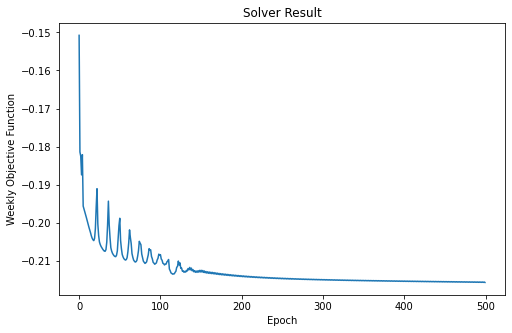

{'annualized return': DeviceArray(0.0382458, dtype=float32),
 'annualized stddev': DeviceArray(0.02414265, dtype=float32),
 'annualized sharpe ratio': DeviceArray(1.5841593, dtype=float32),
 'EDV': DeviceArray(3.1557467, dtype=float32),
 'GSY': DeviceArray(15.67636, dtype=float32),
 'VGIT': DeviceArray(28.872807, dtype=float32),
 'VGSH': DeviceArray(40.77963, dtype=float32),
 'VGT': DeviceArray(8.9735365, dtype=float32),
 'VHT': DeviceArray(2.5419214, dtype=float32)}

In [194]:
w_covid_obj1, objs = solve_portfolio(inline_obj1, 500, 0.5, 1e-9)
plot_objs(objs)
portfolio_stats(w_covid_obj1)

### Maximize Return

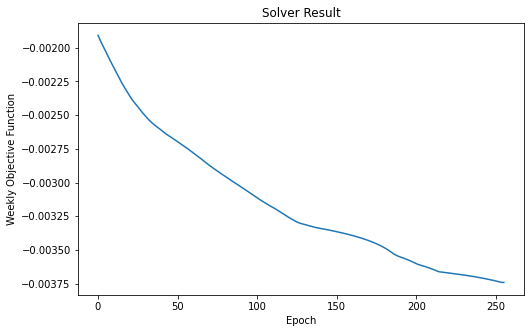

{'annualized return': DeviceArray(0.2143625, dtype=float32),
 'annualized stddev': DeviceArray(0.19139278, dtype=float32),
 'annualized sharpe ratio': DeviceArray(1.1200135, dtype=float32),
 'VGT': DeviceArray(100., dtype=float32)}

In [21]:
w_covid_obj2, objs = solve_portfolio(inline_obj2, 750, .50, 1e-9)
plot_objs(objs)
portfolio_stats(w_covid_obj2)

### Minimize Risk

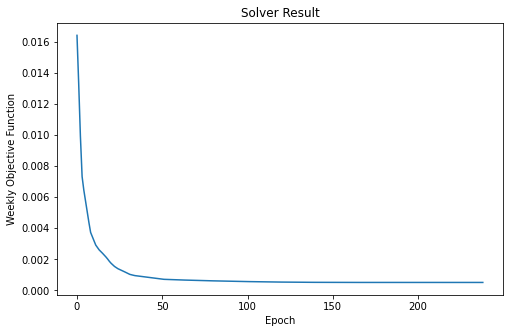

{'annualized return': DeviceArray(-0.00019217, dtype=float32),
 'annualized stddev': DeviceArray(0.00367214, dtype=float32),
 'annualized sharpe ratio': DeviceArray(-0.05233068, dtype=float32),
 'BIL': DeviceArray(90.66221, dtype=float32),
 'GSY': DeviceArray(7.7748156, dtype=float32),
 'VGSH': DeviceArray(1.5629772, dtype=float32)}

In [22]:
w_covid_obj3, objs = solve_portfolio(inline_obj3, 500, .50, 1e-9)
plot_objs(objs)
portfolio_stats(w_covid_obj3)

### Minimize Risk after Target Return

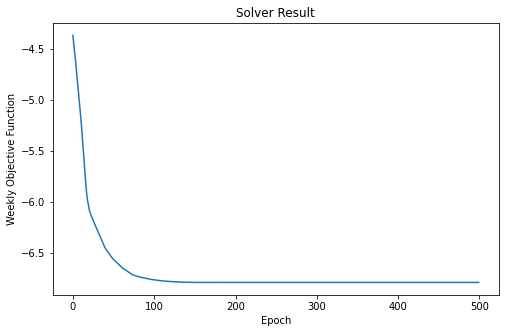

{'annualized return': DeviceArray(0.18439567, dtype=float32),
 'annualized stddev': DeviceArray(0.12152629, dtype=float32),
 'annualized sharpe ratio': DeviceArray(1.5173315, dtype=float32),
 'EDV': DeviceArray(36.843605, dtype=float32),
 'VGT': DeviceArray(63.156403, dtype=float32)}

In [23]:
w_covid_obj4, objs = solve_portfolio(inline_obj4, 500, .50, 1e-9)
plot_objs(objs)
portfolio_stats(w_covid_obj4)

## Without COVID

---

### Define Constants

In [24]:
min_weeks = 52*10

assets = model_matrices(min_weeks, exclude=52)
X = assets['data']
sample_symbols = assets['symbols']
H = assets['hprs']
M, N = assets['dims']
U = assets['mean']
S = assets['cov']

### Maximize Sharpe Ratio

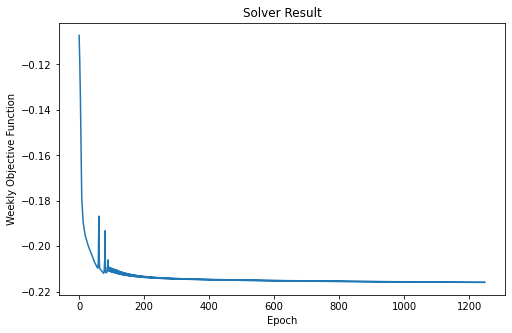

{'annualized return': DeviceArray(0.02781308, dtype=float32),
 'annualized stddev': DeviceArray(0.01751535, dtype=float32),
 'annualized sharpe ratio': DeviceArray(1.5879261, dtype=float32),
 'GSY': DeviceArray(15.0506525, dtype=float32),
 'VGIT': DeviceArray(16.875067, dtype=float32),
 'VGLT': DeviceArray(3.0790632, dtype=float32),
 'VGSH': DeviceArray(54.41242, dtype=float32),
 'VGT': DeviceArray(7.745948, dtype=float32),
 'VHT': DeviceArray(2.8368442, dtype=float32)}

In [25]:
w_nocovid_obj1, objs = solve_portfolio(inline_obj1, 1250, 0.05, 1e-9)
plot_objs(objs)
portfolio_stats(w_nocovid_obj1)

### Maximize Return

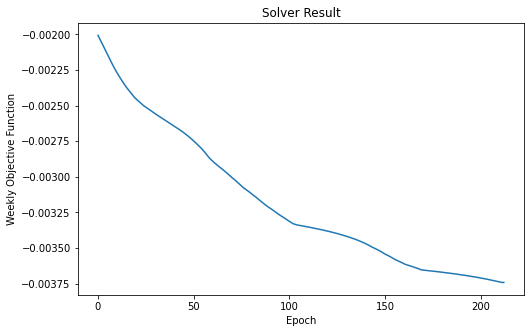

{'annualized return': DeviceArray(0.18673134, dtype=float32),
 'annualized stddev': DeviceArray(0.16798106, dtype=float32),
 'annualized sharpe ratio': DeviceArray(1.1116214, dtype=float32),
 'VGT': DeviceArray(100., dtype=float32)}

In [26]:
w_nocovid_obj2, objs = solve_portfolio(inline_obj2, 750, .50, 1e-10)
plot_objs(objs)
portfolio_stats(w_nocovid_obj2)

### Minimize Risk

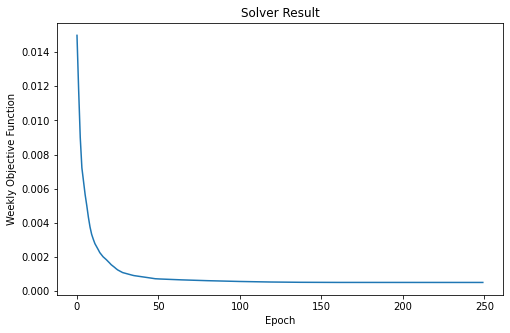

{'annualized return': DeviceArray(-0.00046796, dtype=float32),
 'annualized stddev': DeviceArray(0.00369555, dtype=float32),
 'annualized sharpe ratio': DeviceArray(-0.12662698, dtype=float32),
 'BIL': DeviceArray(90.69324, dtype=float32),
 'GSY': DeviceArray(7.773715, dtype=float32),
 'VGSH': DeviceArray(1.5330538, dtype=float32)}

In [27]:
w_nocovid_obj3, objs = solve_portfolio(inline_obj3, 500, .50, 1e-9)
plot_objs(objs)
portfolio_stats(w_nocovid_obj3)

### Minimize Risk after Target Return

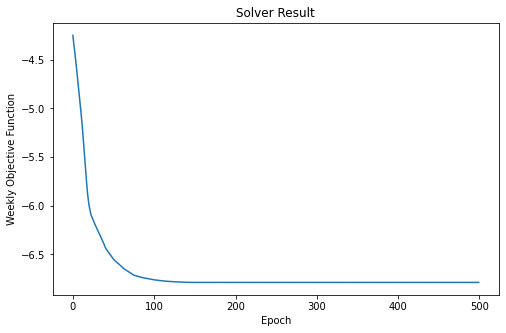

{'annualized return': DeviceArray(0.16412842, dtype=float32),
 'annualized stddev': DeviceArray(0.10288182, dtype=float32),
 'annualized sharpe ratio': DeviceArray(1.5953103, dtype=float32),
 'EDV': DeviceArray(36.843666, dtype=float32),
 'VGT': DeviceArray(63.15634, dtype=float32)}

In [28]:
w_nocovid_obj4, objs = solve_portfolio(inline_obj4, 500, .50, 1e-9)
plot_objs(objs)
portfolio_stats(w_nocovid_obj4)

## Without COVID - xVGT

---

### Define Constants

In [195]:
min_weeks = 52*10

assets = model_matrices(min_weeks, exclude=52, excluded_funds=['VGT'])
X = assets['data']
sample_symbols = assets['symbols']
H = assets['hprs']
M, N = assets['dims']
U = assets['mean']
S = assets['cov']

### Maximize Return

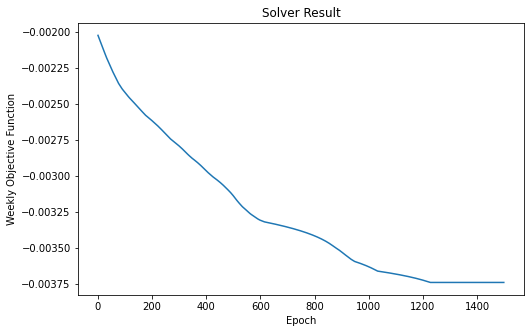

{'annualized return': DeviceArray(nan, dtype=float32),
 'annualized stddev': DeviceArray(nan, dtype=float32),
 'annualized sharpe ratio': DeviceArray(nan, dtype=float32),
 'VHT': DeviceArray(100., dtype=float32)}

In [197]:
w_nocovid_obj2_xvgt, objs = solve_portfolio(inline_obj2, 1500, .1, None)
plot_objs(objs)
portfolio_stats(w_nocovid_obj2_xvgt)

### Minimize Risk after Target Return

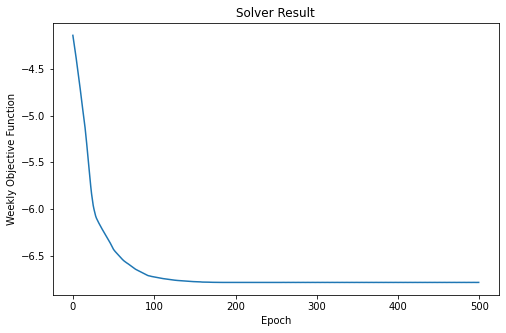

{'annualized return': DeviceArray(nan, dtype=float32),
 'annualized stddev': DeviceArray(nan, dtype=float32),
 'annualized sharpe ratio': DeviceArray(nan, dtype=float32),
 'EDV': DeviceArray(36.843662, dtype=float32),
 'VHT': DeviceArray(63.15634, dtype=float32)}

In [198]:
w_nocovid_obj4_xvgt, objs = solve_portfolio(inline_obj4, 500, .50, 1e-9)
plot_objs(objs)
portfolio_stats(w_nocovid_obj4_xvgt)

## Selected Strategy & Notes

---

### Observations

#### Efficient Portfolio

Both pre and post COVID are able to achieve an annualized sharpe ratio of about 1.52. Post COVID suggests an annualized return just shy of 4%, while pre stands at around 2.5%. The latter seems to have issues converging as evidenced in both the objective function curve as well as low parisomony in the solution.

Intersection:
- EDV 3%
- GSY 16/69%
- VGT 9/3%
- VHT 2.5/1%

COVID Only:
- VGIT 29% (intermediate term treasury)
- VGSH 41% (short term treasury)

No-COVID Only:
- VCSH 21% (short term corporate bonds)
- VMBS 2% (mortgage backed securities)
- VPU 0.25% (utilities)
- VYM 2% (high dividend)

Materially speaking, the COVID period caused the solution to drop short-term corporate bonds in lieu of a mix of ultra-safe treasury bonds. From a purely visual examination I believe this behavior is almost entirely due to several weeks of volatility during March.

#### Maximum Return

Both time periods weight 100% on VGT (technology). Obviously not diversified. This has been where most of the growth has been in recent history, and it's in my opinion likely to continue for the foreseeable future. Also good to note that the singular weighting is not just a function of the exceptional growth during shutdowns.

When VGT is excluded, Pre-COVID weights 100% to VHT.

#### Minimal Risk

Both periods weight heavily on BIL and GSY. Post-COVID puts a 1.52% allocation on VGSH (short term treasury ETF). That looks like overfitting to me - probably a function of some of the perturbations we saw back in March.

#### Targeted Return / Minimal Risk

Either period weights heavily on EDV (extended duration treasury) and VGT. Pre-COVID reduces the 63% weight on VGT to 48%, and EDV 37% to 33%, putting the difference into VHT (health care).

Pre-COVID xVHT weights 60/40 VHT/EDV.

### Selected Strategy

While the risk/reward tradeoff of the portfolio optimized for the sharpe ratio is appealing, the expected annualized return is below what I'm looking for.

## Rolling Analysis

---

In [32]:
f = inline_obj1
g = grad(f)
epochs = 500
alpha = 0.75

portfolios = {}

for min_m in np.flip(np.unique(np.sort(available_weeks)))[2:-2]:
    print(f"Building portfolio for funds with at least {min_m} weeks of price history.")
    portfolios[min_m] = {}
    
    assets = model_matrices(min_m)
    X = assets['data']
    sample_symbols = assets['symbols']
    H = assets['hprs']
    M, N = assets['dims']
    U = assets['mean']
    S = assets['cov']
    
    objs = []
    w = wts(N)
    
    for epoch in range(epochs):
        w -= alpha*g(w)
        o = f(w)
        objs.append(o)

    w = rescale_weights(w)
    
    portfolios[min_m]['symbols'] = sample_symbols
    portfolios[min_m]['w'] = w
    portfolios[min_m]['objs'] = objs

Building portfolio for funds with at least 897 weeks of price history.
Building portfolio for funds with at least 884 weeks of price history.
Building portfolio for funds with at least 849 weeks of price history.
Building portfolio for funds with at least 826 weeks of price history.
Building portfolio for funds with at least 766 weeks of price history.
Building portfolio for funds with at least 761 weeks of price history.
Building portfolio for funds with at least 750 weeks of price history.
Building portfolio for funds with at least 738 weeks of price history.
Building portfolio for funds with at least 722 weeks of price history.
Building portfolio for funds with at least 717 weeks of price history.
Building portfolio for funds with at least 710 weeks of price history.
Building portfolio for funds with at least 702 weeks of price history.
Building portfolio for funds with at least 680 weeks of price history.
Building portfolio for funds with at least 675 weeks of price history.
Buildi

In [33]:
allocations = {}
total_wt = sum([k for k in portfolios.keys()])

for k in portfolios.keys():
    for i in range(len(portfolios[k]['symbols'])):
        fund = portfolios[k]['symbols'][i]
        allocation = portfolios[k]['w'][0, i]
        wtd_alloc = k*allocation
        
        if fund in allocations:
            allocations[fund].append(wtd_alloc)
        else:
            allocations[fund] = [wtd_alloc]

In [34]:

accum = 0
for k in allocations.keys():
    allo = sum(allocations[k])/total_wt
    accum += allo
    print(f"{k}: {allo}")

VTI: 0.03157442808151245
VTIVX: 0.0
VXF: 0.01614309474825859
VAW: 0.0
VB: 0.0
VBK: 0.0
VBR: 0.0
VCR: 0.002962223021313548
VDC: 0.1389983594417572
VFH: 0.0
VGT: 0.20692336559295654
VHT: 0.04309823736548424
VO: 0.0
VPU: 0.0038554202765226364
VTV: 0.0
VUG: 0.0
VV: 0.0
VDE: 0.0
VIS: 0.0
VNQ: 0.0
VOX: 0.0
VGK: 0.0
VPL: 0.0
VWO: 0.0
VIG: 0.0
VFIFX: 0.0
VFORX: 0.0
VOE: 0.0
VOT: 0.0
VYM: 0.0
VEU: 0.0
BIV: 0.005915001034736633
BLV: 0.0004782133619301021
BND: 0.006724606268107891
BSV: 0.22038888931274414
BIL: 0.0
VEA: 0.0
MGC: 0.0
MGK: 0.0
MGV: 0.0
EDV: 0.011936487630009651
GSY: 0.04942627623677254
VT: 0.0
VSS: 0.0
VCIT: 0.0
VCLT: 0.0
VCSH: 0.0
VGIT: 0.07043639570474625
VGSH: 0.1865108609199524
VMBS: 0.0
VGLT: 0.0011460029054433107
VFFVX: 0.0
IVOG: 0.0
IVOO: 0.0
IVOV: 0.0
VIOG: 0.0
VIOO: 0.0
VIOV: 0.0
VOO: 0.0
VOOG: 0.0
VOOV: 0.0
VONE: 0.0
VONG: 0.0
VONV: 0.0
VTHR: 0.0
VTWG: 0.0
VTWO: 0.0
VTWV: 0.0
VNQI: 0.0
VXUS: 0.0
VTTSX: 0.0
VTIP: 0.0
SPHD: 0.0
BNDX: 0.003482147818431258
VWOB: 0.0
VTEB: 0.0


## Selected Portfolio

---

## Selected Portfolio vs. Target Date Funds

---

## Finalization

---

### Visualize Hypothetical Portfolio Performance

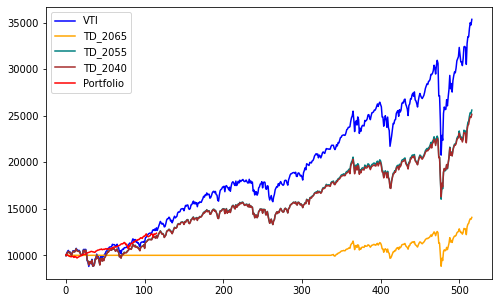

In [35]:
# Prices
VTI = price_mat.VTI.iloc[-min_weeks:-1].values
TD_2065 = price_mat.VLXVX.iloc[-min_weeks:-1].values
TD_2055 = price_mat.VFFVX.iloc[-min_weeks:-1].values
TD_2040 = price_mat.VFORX.iloc[-min_weeks:-1].values
port = jnp.matmul(X.values, w.transpose())

# Returns
VTI = VTI[1:-1]/VTI[0:-2]
TD_2065 = TD_2065[1:-1]/TD_2065[0:-2]
TD_2055 = TD_2055[1:-1]/TD_2055[0:-2]
TD_2040 = TD_2040[1:-1]/TD_2040[0:-2]
port = port[1:-1]/port[0:-2]

TD_2065 = np.nan_to_num(TD_2065, nan=1.00)

# Relative to $10K initial investment
VTI = 10000.00 * np.cumprod(VTI)
TD_2065 = 10000.00 * np.cumprod(TD_2065)
TD_2055 = 10000.00 * np.cumprod(TD_2055)
TD_2040 = 10000.00 * np.cumprod(TD_2040)
port = 10000.00 * np.cumprod(port)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(VTI, c='b', label='VTI')
ax.plot(TD_2065, c='orange', label='TD_2065')
ax.plot(TD_2055, c='teal', label='TD_2055')
ax.plot(TD_2040, c='brown', label='TD_2040')
ax.plot(port, c='r', label='Portfolio')
plt.legend(loc=2)
plt.show()